In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from optimizers.simulations.order import simulate_from_order_func
from optimizers.utils._utils import get_csv_data
from optimizers.utils.cross_validators import vbt_cv_sliding_constructor

In [32]:
pair = "thetafil"
slicer = 1000
opens = get_csv_data(f"data/{pair}_hourly_opens.csv")[slicer:]
closes = get_csv_data(f"data/{pair}_hourly_closes.csv")[slicer:]
print(f"Full data length: {closes.shape[0]}")

train_opens, opens = train_test_split(opens, test_size=0.30, train_size=0.70, shuffle=False)
train_closes, closes = train_test_split(closes, test_size=0.30, train_size=0.70, shuffle=False)
close_folds = vbt_cv_sliding_constructor(train_closes, n_splits=3)
open_folds = vbt_cv_sliding_constructor(train_opens, n_splits=3)

print(f"Test data length: {opens.shape[0]}")
print(f"Train fold length {close_folds[0].shape[0]}")

Full data length: 13128
Test data length: 3939
Train fold length 3063


In [33]:
# BNB -> TRX 550 2.1 -2.5 1.9 1e-5 1.5 CUMMLOG 0.0006 <- works dur 360/38 trades per epoch
# EOS FIL works on a CUMMLOG model but has volatility in per trade returns
# FIL THETA & LINK CHZ, BTC ZEC. BTCZEC might work, but had generalization issues
# ADA ZEC is untestable due to massive regime shift mid test set for LOG model
# Something is bizarre and wrong with the ADA ZEC data; needs review?
# BSV 1INCH 70  2.1 -2.4 1.3 5.000000e-07 0.00030 CUMMLOG <- does not work past 10bps slippage
# XLM1INCH, LTCCHZ, DGBCAKE, NEODGB, DGBDASH, GRT1INCH failed backtesting
# THETA FIL 100 1.2 -1.2 0.3 9.e-8 4.e-5 LOG seems to work
# BATANKR 303 0.7 -2.7 0.4 3.e-9 1.7e-5 LOG
# LTCCHZ works, but apparently failed to hedge (same issue as with CHZWIN)

PERIOD = 100
UPPER = 1.2
LOWER = -1.2
EXIT = 0.3
DELTA = 9.e-8
VT = 4.e-5
BURNIN = 500
MODEL = 'default'
HEDGE = 'beta'
SLIPPAGE = 0.0020
FREQ = "h"

In [34]:
pf = simulate_from_order_func(
    closes, opens,
    period=PERIOD,
    upper=UPPER,
    lower=LOWER,
    exit=EXIT,
    delta=DELTA,
    vt=VT,
    burnin=BURNIN,
    freq=FREQ,
    hedge=HEDGE,
    mode=MODEL,
    slippage=SLIPPAGE,
    order_size=0.10,
)

-0.15894225327471176


<AxesSubplot:xlabel='time'>

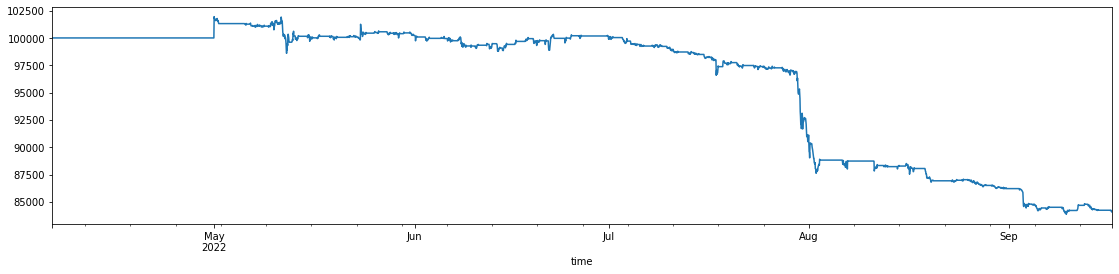

In [35]:
print(pf.total_return())
pf.value().plot(figsize=(19,4))

In [36]:
res = pf.trades.records_readable.groupby("Entry Timestamp").sum()

print(f"Total trades: {res.shape[0]}")
print(f"Executed trades: {pf.trades.records_readable.shape[0]}")
print(f"Profit Ratio: {res.PnL[res.PnL > 0].median() / np.abs(res.PnL[res.PnL < 0].median()):.3f}")
print(f"Net long-short win rate: {res.PnL[res.PnL > 0].shape[0] / res.shape[0] * 100:.2f}%")
print(f"Median trade profit: {res.PnL.median():.2f}")
print(f"Mean trade profit: {res.PnL.mean():.2f}")
print(f"STD of trade profit: {res.PnL.std():.2f}")
print(f"Sharpe ratio: {pf.sharpe_ratio():.4f}")

Total trades: 119
Executed trades: 238
Profit Ratio: 0.639
Net long-short win rate: 39.50%
Median trade profit: -23.56
Mean trade profit: -133.56
STD of trade profit: 556.58
Sharpe ratio: -3.7845


<AxesSubplot:xlabel='Entry Timestamp'>

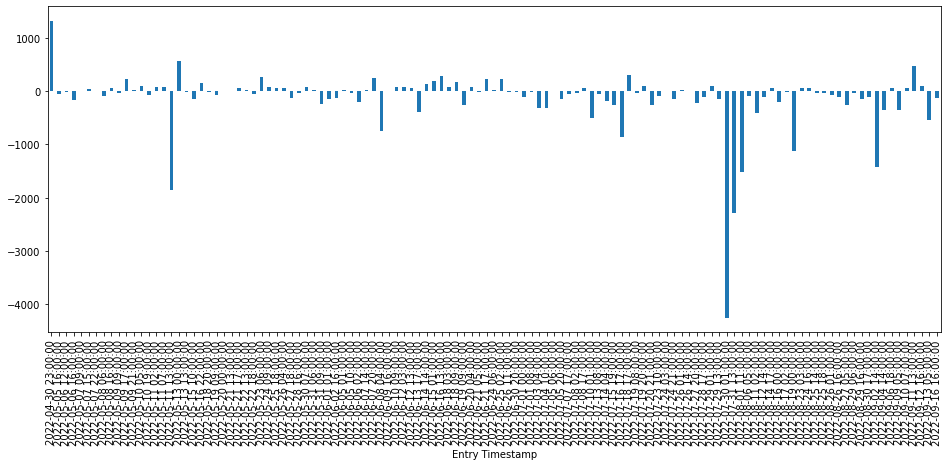

In [37]:
res.PnL.plot(kind="bar", figsize=(16,6))

In [38]:
pf.trades.records_readable.sort_values('Entry Timestamp')

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,THETAUSDT,4289.820257,2022-04-30 23:00:00,2.335161,8.013937,2022-05-01 16:00:00,2.344502,8.045992,24.009566,0.002397,Long,Closed,0
119,119,FILUSDT,913.258973,2022-04-30 23:00:00,16.988754,12.412106,2022-05-01 16:00:00,15.552543,11.362800,1287.858042,0.083007,Short,Closed,119
1,1,THETAUSDT,4455.815086,2022-05-05 16:00:00,2.266658,8.079846,2022-05-05 23:00:00,2.263819,8.069726,-3.499512,-0.000346,Short,Closed,1
120,120,FILUSDT,1087.155853,2022-05-05 16:00:00,13.846337,12.042501,2022-05-05 23:00:00,13.824995,12.023939,-47.269390,-0.003140,Long,Closed,120
2,2,THETAUSDT,4638.408626,2022-05-06 12:00:00,2.185763,8.110769,2022-05-06 15:00:00,2.225740,8.259112,169.058853,0.016675,Long,Closed,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,116,THETAUSDT,7186.441990,2022-09-12 16:00:00,1.180556,6.787200,2022-09-12 17:00:00,1.171951,6.737729,-75.364262,-0.008883,Long,Closed,116
236,236,FILUSDT,1892.407273,2022-09-13 05:00:00,6.424824,9.726707,2022-09-14 20:00:00,5.888000,8.913996,-1034.529588,-0.085088,Long,Closed,236
117,117,THETAUSDT,7202.014309,2022-09-13 05:00:00,1.175444,6.772454,2022-09-14 20:00:00,1.105807,6.371231,488.384426,0.057691,Short,Closed,117
118,118,THETAUSDT,7817.723182,2022-09-16 16:00:00,1.079455,6.751102,2022-09-16 23:00:00,1.083200,0.000000,22.529399,0.002670,Long,Open,118
